Changelog:  (Last Updated 2025-02-26)

# Probabilistic ML: Assignment 3
- **Deadline**: 2025-03-16 (March 16th 2025, 23:59)
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.

- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.

Note to TA: I collaborated with classmate William Boitor on this assignment.

# 1. [54pts] Stochastic Variational Inference in the TrueSkill Model

## Background

We'll continue working with [TrueSkill](http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) model, a player ranking system for competitive games originally developed for Halo 2. Recall the model:


## Model definition

We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_i - z_j)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.


In [63]:
!pip install wget
import os
import os.path
import matplotlib.pyplot as plt
import wget
import pandas as pd
import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch
import random
from torch import nn
from torch.distributions.normal import Normal
from functools import partial
from tqdm import trange, tqdm_notebook

# Helper function
def diag_gaussian_log_density(x, mu, std):
    # axis=-1 means sum over the last dimension.
    m = Normal(mu, std)
    return torch.sum(m.log_prob(x), axis=-1)

## Implementing the TrueSkill Model



This part was mostly done in Assignment 2. We will recall some useful functions.

**a)** The function $\texttt{log_joint_prior}$ computes the log of the prior, jointly evaluated over all player's skills.

In [64]:
def log_joint_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

**b)** The function `logp_a_beats_b` that, given a pair of skills $z_a$ and $z_b$, evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.

To ensure numerical stability, we use the function `np.log1p` that computes $\log(1 + x)$ in a numerically stable way.  Or even better, use `np.logaddexp`.

In [65]:
def logp_a_beats_b(z_a, z_b):
    return -torch.logaddexp(torch.tensor([0.0]), z_b - z_a)

def log_prior_over_2_players(z1, z2):
    m = Normal(torch.tensor([0.0]), torch.tensor([[1.0]]))
    return m.log_prob(z1) + m.log_prob(z2)

def prior_over_2_players(z1, z2):
    return torch.exp(log_prior_over_2_players(z1, z2))

def log_posterior_A_beat_B(z1, z2):
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
    return torch.exp(log_posterior_A_beat_B(z1, z2))

def log_posterior_A_beat_B_20_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 20.0 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_20_times(z1, z2):
    return torch.exp(log_posterior_A_beat_B_20_times(z1, z2))

def log_posterior_beat_each_other_20_times(z1, z2):
    return log_prior_over_2_players(z1, z2) \
        + 20.* logp_a_beats_b(z1, z2) \
        + 20.* logp_a_beats_b(z2, z1)

def posterior_beat_each_other_20_times(z1, z2):
    return torch.exp(log_posterior_beat_each_other_20_times(z1, z2))

The following functions will be used for plotting.  Note that `plot_2d_fun` can now take an optional second function, so you can compare two functions.

In [66]:
# Plotting helper functions for free
def plot_isocontours(ax, func, xlimits=[-4, 4], ylimits=[-4, 4], steps=101, cmap="summer"):
    x = torch.linspace(*xlimits, steps=steps)
    y = torch.linspace(*ylimits, steps=steps)
    X, Y = torch.meshgrid(x, y)
    Z = func(X, Y)
    plt.contour(X, Y, Z, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", f2=None, scatter_pts=None):
    # This is the function your code should call.
    # f() should take two arguments.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if f2 is not None:
      plot_isocontours(ax, f2, cmap='winter')

    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()

## **1.1 [20pts]** Stochastic Variational Inference on Two Players and Toy Data

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing.

In this question we will  approximate posterior distributions with gradient-based stochastic variational inference.

The parameters are $\phi = (\mu,\log(\sigma))$. Notice that instead of $\sigma$ (which is constrained to be positive), we work with $\log(\sigma)$, removing the constraint. This way, we can do unconstrained gradient-based optimization.



**a) [9pts]** Implement the missing lines in the below code, to complete the evidence lower bound function and the reparameterized sampler for the approximate posterior.

Hint 1: You must use the reparametrization trick in your sampler if you want your gradients to be unbiased.

Hint 2: If you're worried you got these wrong, you can check that the sampler matches the log pdf by plotting a histogram of samples against a plot of the pdf.

In [67]:
def diag_gaussian_samples(mean, log_std, num_samples):
    # mean and log_std are (D) dimensional vectors
    # Return a (num_samples, D) matrix, where each sample is
    # from a diagonal multivariate Gaussian.

    # TODO.  You might want to use torch.randn(). Remember
    # you must use the reparameterization trick.  Also remember that
    # we are parameterizing the _log_ of the standard deviation.
    return mean + torch.exp(log_std) * torch.randn(num_samples, mean.shape[-1])

def diag_gaussian_logpdf(x, mean, log_std):
    # Evaluate the density of a batch of points on a
    # diagonal multivariate Gaussian. x is a (num_samples, D) matrix.
    # Return a tensor of shape (num_samples)
    return diag_gaussian_log_density(x, mean, torch.exp(log_std))

def batch_elbo(logprob, mean, log_std, num_samples):
    # TODO: Use simple Monte Carlo to estimate ELBO
    # on a batch of size num_samples
    z = diag_gaussian_samples(mean, log_std, num_samples)
    return torch.mean(logprob(z) - diag_gaussian_logpdf(z, mean, log_std))


**b) [4pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters, and returns an unbiased estimate of the negative elbo using $\texttt{num_samples_per_iter}$ samples, to approximate the joint posterior over skills conditioned on observing player A winning 20 games.

Note: We want a _negative_ ELBO estimate, because the convention in optimization is to minimize functions, and we want to maximize the ELBO.

In [68]:
# Hyperparameters
num_players = 2
n_iters = 1200
stepsize = 0.0001
num_samples_per_iter = 80

def log_posterior_A_beat_B_20_times_1_arg(z1z2):
    return log_posterior_A_beat_B_20_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params): # The loss function to be minimized.
    # TODO.  Hint:  This can be done in one line.
    return -batch_elbo(log_posterior_A_beat_B_20_times_1_arg, params[0], params[1], num_samples_per_iter)

**c) [1pts]** Initialize a set of variational parameters and optimize them to approximate the joint where we observe player A winning 20 games. Report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Hint:  Any initialization should be fine.  How many variational parameters do you need?

Optimizing variational parameters...


  4%|▍         | 49/1200 [00:00<00:02, 483.99it/s]

Iteration 0 lower bound 43.58892822265625
Iteration 25 lower bound 28.1918888092041
Iteration 50 lower bound 17.301677703857422
Iteration 75 lower bound 10.29774284362793


 16%|█▌        | 187/1200 [00:00<00:02, 428.41it/s]

Iteration 100 lower bound 8.961042404174805
Iteration 125 lower bound 7.611558437347412
Iteration 150 lower bound 6.464808464050293
Iteration 175 lower bound 5.6350483894348145


 24%|██▍       | 285/1200 [00:00<00:01, 465.45it/s]

Iteration 200 lower bound 5.533292770385742
Iteration 225 lower bound 4.596102714538574
Iteration 250 lower bound 4.511479377746582
Iteration 275 lower bound 4.739588260650635
Iteration 300 lower bound 4.126526832580566


 32%|███▏      | 380/1200 [00:00<00:01, 467.58it/s]

Iteration 325 lower bound 4.082578182220459
Iteration 350 lower bound 4.289016246795654
Iteration 375 lower bound 4.389703273773193
Iteration 400 lower bound 3.840669631958008


 39%|███▉      | 470/1200 [00:01<00:02, 350.76it/s]

Iteration 425 lower bound 4.005522727966309
Iteration 450 lower bound 3.9718146324157715
Iteration 475 lower bound 3.992616653442383


 46%|████▋     | 557/1200 [00:01<00:01, 382.05it/s]

Iteration 500 lower bound 3.861557722091675
Iteration 525 lower bound 4.0480852127075195
Iteration 550 lower bound 3.922637939453125
Iteration 575 lower bound 3.8836829662323


 57%|█████▋    | 687/1200 [00:01<00:01, 395.43it/s]

Iteration 600 lower bound 3.86003041267395
Iteration 625 lower bound 4.070979118347168
Iteration 650 lower bound 4.066380500793457
Iteration 675 lower bound 4.032373905181885


 64%|██████▍   | 771/1200 [00:01<00:01, 391.90it/s]

Iteration 700 lower bound 3.955857038497925
Iteration 725 lower bound 3.771951198577881
Iteration 750 lower bound 3.9944374561309814


 71%|███████   | 851/1200 [00:02<00:00, 380.17it/s]

Iteration 775 lower bound 3.9077343940734863
Iteration 800 lower bound 3.8397278785705566
Iteration 825 lower bound 3.955900192260742
Iteration 850 lower bound 3.9135727882385254


 75%|███████▍  | 895/1200 [00:02<00:00, 395.11it/s]

Iteration 875 lower bound 4.04210090637207
Iteration 900 lower bound 4.055530071258545
Iteration 925 lower bound 3.9783546924591064


 84%|████████▍ | 1011/1200 [00:02<00:00, 345.87it/s]

Iteration 950 lower bound 4.031628131866455
Iteration 975 lower bound 3.9523537158966064
Iteration 1000 lower bound 3.9251182079315186


 91%|█████████▏| 1095/1200 [00:02<00:00, 380.96it/s]

Iteration 1025 lower bound 3.9747161865234375
Iteration 1050 lower bound 3.9490017890930176
Iteration 1075 lower bound 3.8393759727478027
Iteration 1100 lower bound 3.929866313934326


 98%|█████████▊| 1173/1200 [00:03<00:00, 376.97it/s]

Iteration 1125 lower bound 3.9151854515075684
Iteration 1150 lower bound 3.8235116004943848
Iteration 1175 lower bound 3.925126552581787


100%|██████████| 1200/1200 [00:03<00:00, 386.84it/s]



Final loss:
Iteration 1200 lower bound 3.9611430168151855


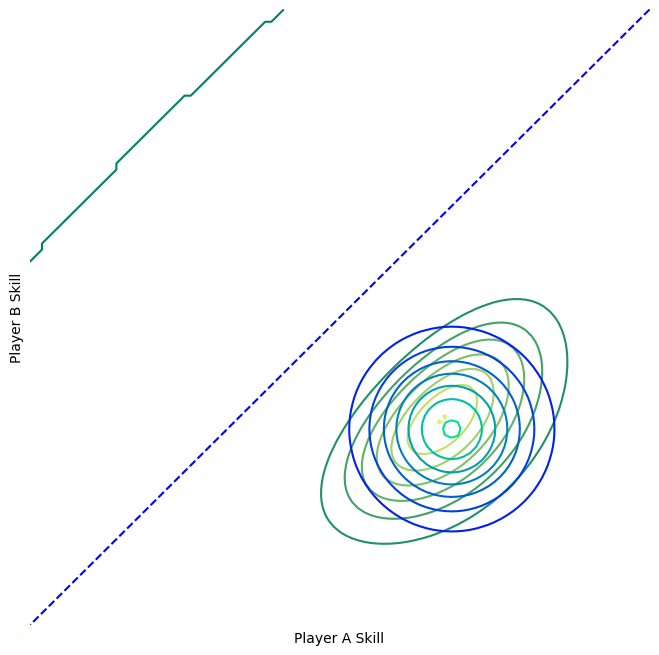

<Figure size 640x480 with 0 Axes>

In [69]:
def callback(params, t):
    if t % 25 == 0:
      print("Iteration {} lower bound {}".format(t, objective(params)))

# Set up optimizer.
D = 2
init_log_std = torch.ones(D, requires_grad=True) # TODO
init_mean = torch.zeros(D, requires_grad=True) # TODO
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)
print("\nFinal loss:"); callback(params, n_iters)

def approx_posterior_2d(z1, z2):
    # The approximate posterior
    mean, logstd = params[0].detach(), params[1].detach()
    return torch.exp(diag_gaussian_logpdf(torch.stack([z1, z2], dim=2), mean, logstd))

plot_2d_fun(posterior_A_beat_B_20_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

**Answer:**

We need 2 variational parameters with dimension $D$ each. The final loss is 3.9611430168151855.

**d) [3pt]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters , and returns a negative elbo estimate using simple Monte carlo with $\texttt{num_samples_per_iter}$ samples, to approximate the joint where we observe player A winning 20 games and player B winning 20 games.

Hint:  You can find analogous functions in the code above.


In [70]:
# Hyperparameters
n_iters = 100
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_beat_each_other_20_times_1_arg(z1z2):
    # z1z2 is a tensor with shape (num_samples x 2)
    # Return a tensor with shape (num_samples)
    return log_posterior_beat_each_other_20_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params):
    return -batch_elbo(log_posterior_beat_each_other_20_times_1_arg, params[0], params[1], num_samples_per_iter)

**e) [3pt]** Run the code below to optimize, and report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Write one or two sentences describing the joint settings of skills that are plausible under the true posterior, but which are not plausible under the approximate posterior.

Finally, answer with one or two sentences:  Would changing the variational approximate posterior from a fully-factorized (diagonal covariance) Gaussian to a non-factorized (fully parameterized covariance) Gaussian make a better approximation in this instance?

Optimizing variational parameters...


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 0 lower bound 63.630332946777344


 20%|██        | 20/100 [00:00<00:00, 194.08it/s]

Iteration 25 lower bound 51.10566329956055
Iteration 50 lower bound 39.924686431884766


100%|██████████| 100/100 [00:00<00:00, 343.02it/s]


Iteration 75 lower bound 35.22320556640625

Final loss:
Iteration 100 lower bound 31.548410415649414


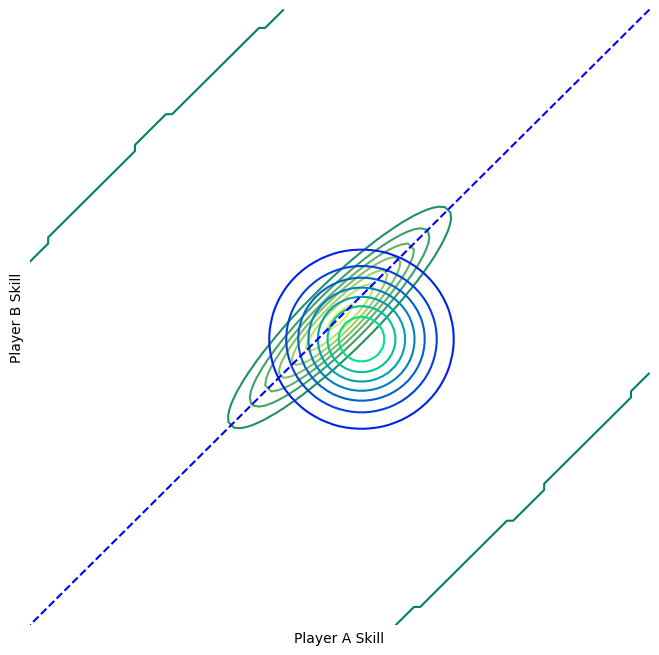

<Figure size 640x480 with 0 Axes>

In [71]:
# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)
print("\nFinal loss:"); callback(params, n_iters)

plot_2d_fun(posterior_beat_each_other_20_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

**(Answer here)**

The final loss is 31.548410415649414.

Under the true posterior, it is plausible for the players to both have high or low skills, but this is not plausible under the approximate posterior.

Yes, since the diagonal covariance matrix is likely an oversimplistic approximation (the approximate posterior in the graph is different from the true posterior, and we should expect non-zero covariance between the skills of different players).

## 1.2 [34 pts] Approximate inference conditioned on real data

The dataset contains data on 2500 games amongst 33 Premier League teams:
 - names is a 33 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2500 by 2 matrix of game outcomes, one row per game.

The first column contains the indices of the team who won.
The second column contains the indices of the team who lost.

It is based on the following kaggle dataset: https://www.kaggle.com/datasets/evangower/premier-league-matches-19922022

<!-- The dataset contains data on 2546 chess games amongst 1434 players:
 - names is a 1434 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2546 by 2 matrix of game outcomes (actually chess matches), one row per game.

The first column contains the indices of the players who won.
The second column contains the indices of the player who lost.

It is based on the kaggle chess dataset: https://www.kaggle.com/datasets/datasnaek/chess -->




In [72]:
# Download the dataset
!curl -L -o premier-league-matches-19922022.zip\
  https://www.kaggle.com/api/v1/datasets/download/evangower/premier-league-matches-19922022
!unzip premier-league-matches-19922022.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 81859  100 81859    0     0   152k      0 --:--:-- --:--:-- --:--:--  152k
Archive:  premier-league-matches-19922022.zip
replace premier-league-matches.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [73]:
from sklearn.preprocessing import LabelEncoder

def load_games():
    dataset = pd.read_csv("premier-league-matches.csv")
    mini_ds = dataset[dataset['FTR'] != 'D'][-2500:]
    all_teams = pd.concat((mini_ds['Home'], mini_ds['Away'])).unique()
    encoder = LabelEncoder()
    encoder.fit(all_teams)
    mini_ds['HomeId'] = encoder.transform(mini_ds['Home'])
    mini_ds['AwayId'] = encoder.transform(mini_ds['Away'])

    winner_ids = np.where(mini_ds['FTR'] == 'H', mini_ds['HomeId'], mini_ds['AwayId'])
    loser_ids = np.where(mini_ds['FTR'] == 'H', mini_ds['AwayId'], mini_ds['HomeId'])
    games = np.column_stack((winner_ids, loser_ids))
    names = encoder.classes_

    return games, names

games, names = load_games()
games = torch.LongTensor(games)



**a) [0pt]** Assuming all game outcomes are i.i.d. conditioned on all players' skills, the function $\texttt{log_games_likelihood}$ takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihood for all those observations given all the skills.


In [74]:
def log_games_likelihood(zs, games):
    winning_player_ixs = games[:,0]
    losing_player_ixs = games[:,1]

    winning_player_skills = zs[:, winning_player_ixs]
    losing_player_skills = zs[:, losing_player_ixs]

    log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)
    return torch.sum(log_likelihoods, dim=1)

In [75]:
def log_joint_probability(zs):
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

**b) [4pt]** Write a new objective function like the one from the previous question.

Below, we initialize a variational distribution and fit it to the joint distribution with all the observed tennis games from the dataset.

In [76]:
# Hyperparameters
num_players = 33
n_iters = 200
stepsize = 0.0001
num_samples_per_iter = 50

def objective(params):
    return -batch_elbo(log_joint_probability, params[0], params[1], num_samples_per_iter)

**c) [3pts]** Optimize, and report the final loss.

In [77]:
# Set up optimizer.
init_mean = torch.zeros(num_players, requires_grad=True)
init_log_std  = torch.zeros(num_players, requires_grad=True)
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Optimize and print loss in a loop
# HINT: you can use the callback() function to report loss
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)
print("\nFinal loss:"); callback(params, n_iters)

Optimizing variational parameters...


 12%|█▏        | 23/200 [00:00<00:00, 221.54it/s]

Iteration 0 lower bound 2261.7763671875
Iteration 25 lower bound 1698.5869140625


 46%|████▌     | 91/200 [00:00<00:00, 214.12it/s]

Iteration 50 lower bound 1584.0447998046875
Iteration 75 lower bound 1554.425048828125


 68%|██████▊   | 135/200 [00:00<00:00, 214.99it/s]

Iteration 100 lower bound 1539.704833984375
Iteration 125 lower bound 1530.6962890625


 90%|█████████ | 180/200 [00:00<00:00, 213.30it/s]

Iteration 150 lower bound 1525.4915771484375
Iteration 175 lower bound 1521.49169921875


100%|██████████| 200/200 [00:00<00:00, 214.88it/s]


Final loss:
Iteration 200 lower bound 1519.229248046875


**Answer:**

The final loss is 1519.229248046875.

**d) [1pt]** Plot the approximate mean and variance of all players, sorted by skill.

<ErrorbarContainer object of 3 artists>

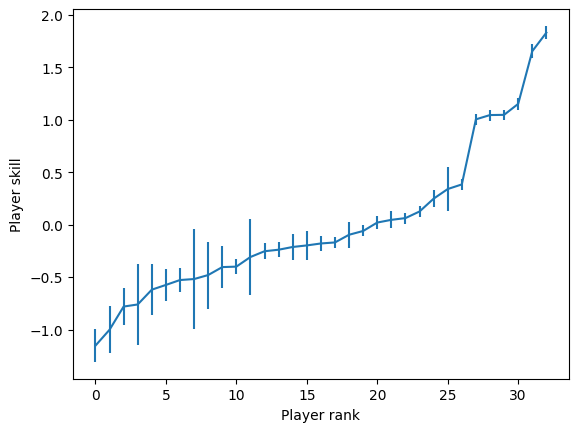

In [78]:
# Hint: You should use .detach() before you do anything with the params tensors
mean_skills = params[0].detach()
logstd_skills = params[1].detach()
var_skills = torch.exp(2 * logstd_skills)
order = torch.argsort(mean_skills)

plt.xlabel("Player rank"); plt.ylabel("Player skill")
plt.errorbar(range(num_players), mean_skills[order], var_skills[order])

**e) [1pts]** List the names of the 10 players with the highest mean skill under the variational model.

In [79]:
for i in range(1,11):
    # TODO
    print(names[order[-i]])

Manchester City
Liverpool
Manchester Utd
Arsenal
Tottenham
Chelsea
Leicester City
Brentford
Wolves
West Ham


**f) [3pt]** Plot samples from the joint posterior over the skills of Arsenal and Liverpool. Based on your samples, describe in a sentence the relationship between the skills of the teams. (Is one better than the other? Are they approximately even?)

Arsenal
Liverpool


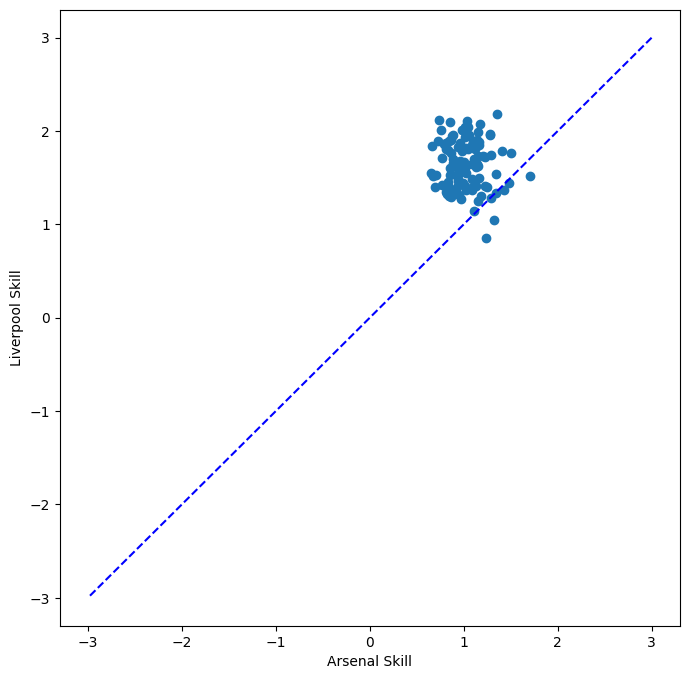

In [80]:
arsenal_ix = 0
liverpool_ix = 15
print(names[arsenal_ix])
print(names[liverpool_ix])

fig = plt.figure(figsize=(8,8), facecolor='white')

# Label each with "<player> Skill"
plt.xlabel("Arsenal Skill")
plt.ylabel("Liverpool Skill")

plt.plot([3, -3], [3, -3], 'b--') # Line of equal skill

samples = diag_gaussian_samples(mean_skills, logstd_skills, 100)

# TODO:  Hint:  Use plt.scatter()
plt.scatter(samples[:, arsenal_ix], samples[:, liverpool_ix])

**(Answer here)**

From the plot, Liverpool has higher skill than Arsenal since most of the points are above the line of equal skill.

**g) [8pts]** Derive the exact probability under a factorized Gaussian over two players’ skills that one has higher skill than the other, as a function of the two means and variances over their skills. Express your answer in terms of the cumulative distribution function of a one-dimensional Gaussian random variable.

- Hint 1: Use a linear change of variables $y_A, y_B = z_A − z_B , z_B$. What does the line of equal skill look like after this transformation?
- Hint 2: If $X \sim \mathcal N (\mu, \Sigma)$, then $AX \sim \mathcal N (A\mu, A\Sigma A^T)$ where $A$ is a linear transformation.
- Hint 3: Marginalization in Gaussians is easy: if $X \sim \mathcal N (\mu, \Sigma)$, then the $i$th element of $X$ has a
marginal distribution $X_i \sim \mathcal N (\mu_i , \Sigma_{ii})$.

**Your answer here.**

Let $z_A\sim\mathcal{N}(\mu_1,\sigma_1^2)$ and $z_B\sim\mathcal{N}(\mu_2,\sigma_2^2)$ such that $z=\begin{bmatrix} z_A \\ z_B \end{bmatrix}\sim\mathcal{N}(\mu,\Sigma)$ where $\mu=\begin{bmatrix}\mu_1 \\ \mu_2 \end{bmatrix}$ and $\Sigma=\begin{bmatrix} \sigma_1^2 & 0 \\ 0 & \sigma_2^2 \end{bmatrix}$. Define $y_A=z_A-z_B$, $y_B=z_B$, and $A=\begin{bmatrix} 1 & -1 \\ 0 & 1 \end{bmatrix}$. Note that the line of equal skill will be a horizontal line on the $x$ axis after this transformation. Since $z\sim\mathcal{N}(\mu,\Sigma)$, we have $y=Az\sim\mathcal{N}(A\mu,A\Sigma A^T)$ where \begin{align}
  A\mu &= \begin{bmatrix} 1 & -1 \\ 0 & 1 \end{bmatrix}\begin{bmatrix} \mu_1 \\ \mu_2 \end{bmatrix}=\begin{bmatrix} \mu_1-\mu_2 \\ \mu_2 \end{bmatrix}\\
  A\Sigma A^T &= \begin{bmatrix} 1 & -1 \\ 0 & 1 \end{bmatrix}\begin{bmatrix} \sigma_1^2 & 0 \\ 0 & \sigma_2^2 \end{bmatrix}\begin{bmatrix} 1 & 0 \\ -1 & 1 \end{bmatrix}=\begin{bmatrix} \sigma_1^2+\sigma_2^2 & -\sigma_2^2 \\ -\sigma_2^2 & \sigma_2^2 \end{bmatrix}
\end{align} Thus, $y_A\sim\mathcal{N}(\mu_1-\mu_2,\sigma_1^2+\sigma_2^2)$, so for some $Z\sim\mathcal{N}(0,1)$, \begin{align}
  P(z_A>z_B)&=P(y_A>0)=P(\mu_1-\mu_2+(\sqrt{\sigma_1^2+\sigma_2^2})Z>0)=P(Z>\frac{\mu_2-\mu_1}{\sqrt{\sigma_1^2+\sigma_2^2}})\\
  &=1-P(Z\leq\frac{\mu_2-\mu_1}{\sqrt{\sigma_1^2+\sigma_2^2}})=1-\Phi\Big(\frac{\mu_2-\mu_1}{\sqrt{\sigma_1^2+\sigma_2^2}}\Big)=\Phi\Big(\frac{\mu_1-\mu_2}{\sqrt{\sigma_1^2+\sigma_2^2}}\Big)
\end{align} since $-\Phi(x)=\Phi(-x)$, where $\Phi$ is the standard normal CDF.

**h) [4pts]** Compute the probability under your approximate posterior that Arsenal has higher skill than Liverpool. Compute this quantity exactly using the formula you just derived above, and also estimate it using simple Monte Carlo with 10000 examples.

Hint:  You might want to use `Normal(0,1).cdf()` for the exact formula.

In [81]:
# TODO
def helper(A, B, n):
  m = mean_skills[A] - mean_skills[B]
  v = var_skills[A] + var_skills[B]
  formula = Normal(0,1).cdf(m / torch.sqrt(v))
  z = diag_gaussian_samples(mean_skills, logstd_skills, n)
  mc = np.count_nonzero(z[:, A] > z[:, B]) / z.shape[0]
  return formula, mc

formula, mc = helper(arsenal_ix, liverpool_ix, 10000)
print(f"Estimate using the formula: {formula}")
print(f"Estimate using simple MC: {mc}")

Estimate using the formula: 0.03702044486999512
Estimate using simple MC: 0.0412


**i) [2pts]** Compute the probability that Arsenal is better than the player with the 5th lowest mean skill. Compute this quantity exactly, and then estimate it using simple Monte Carlo with 10000 examples.


In [82]:
# TODO
print(f"Player with the 5th lowest mean skill: {names[order[4]]}")
formula, mc = helper(arsenal_ix, order[4], 10000)
print(f"Estimate using the formula: {formula}")
print(f"Estimate using simple MC: {mc}")

Player with the 5th lowest mean skill: Hull City
Estimate using the formula: 0.9989794492721558
Estimate using simple MC: 0.9986


**j) [4 pts]** Imagine that we knew ahead of time that we were examining the skills of top chess players, and so changed our prior on all players to Normal(5, 1) and re-ran our approximate inference from scratch. Would that change the answer of either of the previous 2 questions, in expectation?

**Your answer here.**

No, since the probabilities of one player being better than another depends on the relative differences between their skills. While the actual skill estimates themselves might be affected, the relative differences between the skills would remain the same in expectation, and thus the probabilities of one player being better would also remain similar.

**k) [4 pts]** Based on all the plots and results in this assignment and HW2, which approximate inference method do you suspect is producing a better overall approximation to the true posterior over all skills conditioned on all games?  Give a short explanation.

**Your answer here.**

HMC likely produces a better overall approximation since the diagonal covariance matrix in the SVI model (which is from the assumption that the skills follow a factorized Normal distribution) is likely not an accurate representation of relative skills between players, which causes the model to badly approximate the true posterior.

# 2. [21pts] Question 2: VAE with synthetic data

In this question, we will train a VAE on a synthetic data which resembles spirals in 2d. We will perform amortized inference with VAEs.

Function below generates the synthetic knot shape data.

In [83]:
def make_banana_data(num_classes, num_per_class, noise_std=0.3):
    # Create points in the shape of a banana
    features = []
    labels = []

    for i in range(num_classes):
        theta = torch.linspace(0, np.pi, num_per_class) + i * (2 * np.pi / num_classes)  # spread across the circle
        x = torch.sin(theta) + noise_std * torch.randn_like(theta)  # add some noise
        y = torch.cos(theta) * (torch.sin(theta) + noise_std * torch.randn_like(theta))  # banana shape, noise too

        features.append(torch.stack([x, y], dim=1))
        labels.extend([i] * num_per_class)

    # Concatenate features and labels
    features = torch.cat(features, dim=0)
    labels = torch.tensor(labels).long()

    # Shuffle the dataset
    perm_ix = torch.randperm(labels.shape[0])
    return labels[perm_ix], features[perm_ix]

We visualize the 2d data generated from the above function. Notice that there are 3 clusters in the input space, each colored with a different color. The VAE will not see the cluster assignments, but we hope to recover this structure in the latent space.

(-1.1521495282649994,
 1.1404964625835419,
 -0.5831249684095383,
 0.5958465665578843)

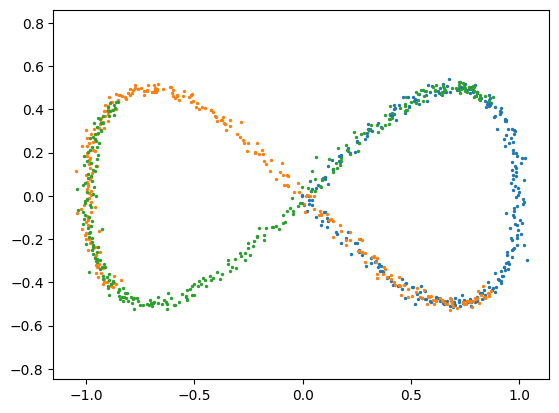

In [84]:
num_clusters = 3
samples_per_cluster = 300
labels, data = make_banana_data(num_clusters, samples_per_cluster, 0.02)

for k in range(num_clusters):
    plt.scatter(data[labels == k, 0], data[labels == k, 1], s=2)

plt.axis("equal")

## 2.1 [12 pts] Implement the missing lines in the below code, to complete the $\texttt{elbo}$ function for a variational autoencoder.

The banana dataset and an example encoder / decoder is provided just to help you debug.


In [85]:
# Generic VAE functions.

def log_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

def diag_gaussian_samples(mean, log_std, num_samples):
    return mean + torch.exp(log_std) * torch.randn(num_samples, mean.shape[-1])

def diag_gaussian_logpdf(x, mean, log_std):
    return diag_gaussian_log_density(x, mean, torch.exp(log_std))

def batch_elbo(  # Simple Monte Carlo estimate of the variational lower bound.
    recognition_net,    # takes a batch of datapoints, outputs mean and log_std of size (batch_size x latent_dim), i.e. log q(z|x)
    decoder_net,        # takes a batch of latent samples, outputs mean and log_std of size (batch_size x data_dim), i.e. log p(x|z)
    log_joint,          # takes decoder_net, a batch of latent samples, and a batch of datapoints, outputs unnormalized log joint, i.e. log p(x,z)
    data                # a.k.a. x
    ):
    #TODO
    q_m, q_std = recognition_net(data)
    z = diag_gaussian_samples(q_m, q_std, len(data))
    return torch.mean(log_joint(decoder_net, z, data) - diag_gaussian_logpdf(z, q_m, q_std))

The below code trains a VAE where the encoder and decoder are both neural networks. The parameters are specified in the starter code.  You don't need to do anything here, this is just to help you debug.

In [86]:
from torch.utils.data import TensorDataset, DataLoader
# Now define a specific VAE for the spiral dataset

data_dimension = 2
latent_dimension = 2

# Define the recognition network.
class RecognitionNet(nn.Module):
    def __init__(self, data_dimension, latent_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dimension, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, latent_dimension) # Output mean of q(z)
        self.std_net = nn.Linear(50, latent_dimension) # Output log_std of q(z)

    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

recognition_net = RecognitionNet(data_dimension, latent_dimension)

# Define the decoder network.
# Note that it has two outputs, a mean and a variance, because
# this model has a Gaussian likelihood p(x|z).
class Decoder(nn.Module):
    def __init__(self, latent_dimension, data_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dimension, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, data_dimension) # Output mean of p(x|z)
        self.std_net = nn.Linear(50, data_dimension) # Output log_std of p(x|z)

    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

decoder_net = Decoder(latent_dimension, data_dimension)

# Set up log likelihood function.
def log_likelihood(decoder_net, latent, data):
    mean, log_std = decoder_net(latent)
    return diag_gaussian_logpdf(data, mean,
                                np.log(0.1) + 0. * log_std)  # Note: we are cheating here and using a fixed noise variance to make optimization more stable.

def log_joint(decoder_net, latent, data):
    return log_prior(latent) + log_likelihood(decoder_net, latent, data)

# Run optimization
optimizer = torch.optim.Adam([{'params': recognition_net.parameters()},
                      {'params': decoder_net.parameters()}], lr=1e-3)
n_iters = 2000
minibatch_size = 300

dataset = TensorDataset(torch.tensor(data))
dataloader = DataLoader(dataset, batch_size=minibatch_size, shuffle=True)

def objective(recognition_net, decoder_net):  # The loss function to be minimized.
    minibatch = next(iter(dataloader))[0]
    return -batch_elbo(
    recognition_net,
    decoder_net,
    log_joint,
    minibatch)

def callback(t):
    if t % 100 == 0:
        print("Iteration {} lower bound {}".format(t, -objective(recognition_net, decoder_net)))

def update():
    optimizer.zero_grad()
    loss = objective(recognition_net, decoder_net)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(t)

<ipython-input-86-26fe4ed13568>:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(data))


Optimizing variational parameters...


  1%|          | 20/2000 [00:00<00:10, 193.74it/s]

Iteration 0 lower bound -29.203327178955078


  6%|▋         | 125/2000 [00:00<00:09, 195.49it/s]

Iteration 100 lower bound -3.2999095916748047


 12%|█▏        | 230/2000 [00:01<00:08, 200.75it/s]

Iteration 200 lower bound -1.1646305322647095


 17%|█▋        | 333/2000 [00:01<00:08, 198.97it/s]

Iteration 300 lower bound -1.139965534210205


 21%|██        | 419/2000 [00:02<00:10, 145.06it/s]

Iteration 400 lower bound -0.909348726272583


 26%|██▋       | 527/2000 [00:03<00:10, 145.09it/s]

Iteration 500 lower bound -0.9723609685897827


 31%|███▏      | 629/2000 [00:03<00:09, 140.17it/s]

Iteration 600 lower bound -0.88350909948349


 37%|███▋      | 732/2000 [00:04<00:06, 192.95it/s]

Iteration 700 lower bound -0.8773610591888428


 42%|████▏     | 836/2000 [00:04<00:05, 202.82it/s]

Iteration 800 lower bound -0.7866259813308716


 47%|████▋     | 941/2000 [00:05<00:05, 200.58it/s]

Iteration 900 lower bound -0.7426890730857849


 51%|█████     | 1024/2000 [00:05<00:04, 198.48it/s]

Iteration 1000 lower bound -0.8647772073745728


 57%|█████▋    | 1131/2000 [00:06<00:04, 201.83it/s]

Iteration 1100 lower bound -0.7578990459442139


 62%|██████▏   | 1239/2000 [00:06<00:03, 206.96it/s]

Iteration 1200 lower bound -0.8229531049728394


 65%|██████▌   | 1302/2000 [00:07<00:05, 129.49it/s]

Iteration 1300 lower bound -0.7488088011741638


 72%|███████▏  | 1439/2000 [00:08<00:03, 177.99it/s]

Iteration 1400 lower bound -0.7877674102783203


 77%|███████▋  | 1541/2000 [00:08<00:02, 179.29it/s]

Iteration 1500 lower bound -0.8175008296966553


 81%|████████▏ | 1626/2000 [00:09<00:01, 195.61it/s]

Iteration 1600 lower bound -0.7385186553001404


 87%|████████▋ | 1733/2000 [00:09<00:01, 204.56it/s]

Iteration 1700 lower bound -0.732720136642456


 92%|█████████▏| 1838/2000 [00:10<00:00, 200.88it/s]

Iteration 1800 lower bound -0.7870941758155823


 96%|█████████▌| 1922/2000 [00:10<00:00, 204.38it/s]

Iteration 1900 lower bound -0.7183759808540344


100%|██████████| 2000/2000 [00:11<00:00, 180.27it/s]


## 2.2 [5 pts]  In this part, we visualize how the data looks like in the latent space. We simply use the trained recognition network (the encoder) to map each input to latent space.


Text(0, 0.5, 'latent dimension 2')

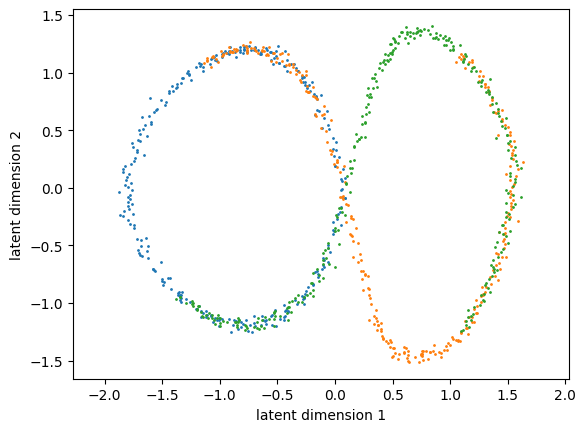

In [87]:
# Show the means of the encoded data in a 2D latent space.
# Don't worry if this doesn't look much like a Gaussian.

for k in range(num_clusters):
    # cur_data =  # TODO get all the data from this cluster.
    # transformed =  # TODO find the mean of q(z|x) for each x.
    cur_data = data[labels == k]
    transformed = recognition_net(cur_data)[0].detach()
    plt.scatter(transformed[:, 0], transformed[:, 1], s=1)

plt.axis("equal")
plt.xlabel("latent dimension 1")
plt.ylabel("latent dimension 2")

## 2.3 [4pts] Generate new data using the decoder and the generative model we just trained.

For this, we simply generate 1500 latent variables in the latent space from the prior and pass it through the decoder network.

You shouldn't expect this to match the data exactly, just to get the overall shape and number of clusters roughly correct.  


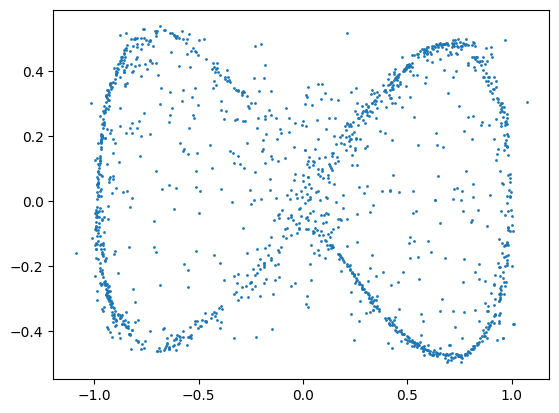

In [88]:
# Sample data from the trained generative model to see if it
# roughly matches the data.  # Note: This doesn't add the likelihood noise,
# although it should if we want it to match the data.

num_samples = 1500
# samples =  # TODO
# transformed =  # TODO
samples = torch.randn(num_samples, latent_dimension) # TODO
transformed = decoder_net(samples)[0].detach() # TODO
plt.scatter(transformed[:, 0], transformed[:, 1], s=1)

Here's a debugging tool only available when both the latent space and the data are both 2-dimensional.  We can show the function being learned by the encoder by showing how it warps a 2D grid into the latent space.

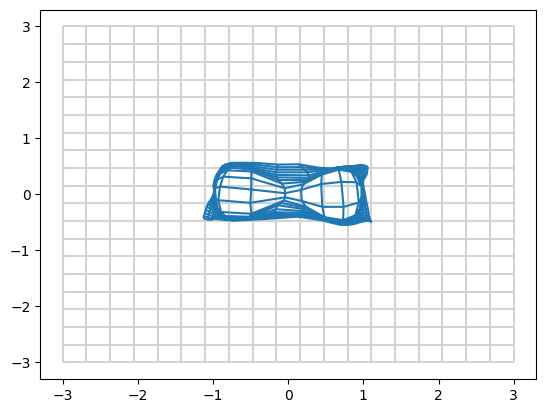

In [89]:
from matplotlib.collections import LineCollection

def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

def f(x,y):
    xy = torch.stack([x.flatten(), y.flatten()], dim=1)
    return decoder_net(xy)

fig, ax = plt.subplots()

grid_x,grid_y = torch.meshgrid(torch.linspace(-3,3,20),torch.linspace(-3,3,20))
plot_grid(grid_x,grid_y, ax=ax,  color="lightgrey")

distx, disty = f(grid_x,grid_y)
distx, disty = distx.reshape(20, 20, 2), disty.reshape(20, 20, 2)
plot_grid(distx[:, :, 0].detach().numpy(), distx[:, :, 1].detach().numpy(), ax=ax, color="C0")

plt.show()

Here, we show the function being learned by the decoder by showing how it warps a 2D grid into the observed space.



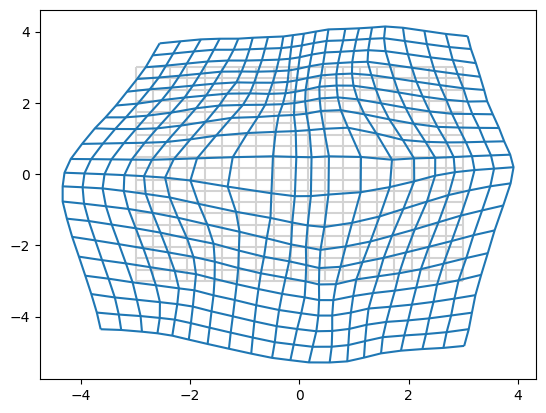

In [90]:
def f(x,y):
    xy = torch.stack([x.flatten(), y.flatten()], dim=1)
    return recognition_net(xy)

fig, ax = plt.subplots()

grid_x,grid_y = torch.meshgrid(torch.linspace(-3,3,20),torch.linspace(-3,3,20))
plot_grid(grid_x,grid_y, ax=ax,  color="lightgrey")

distx, disty = f(grid_x,grid_y)
distx, disty = distx.reshape(20, 20, 2), disty.reshape(20, 20, 2)
plot_grid(distx[:, :, 0].detach().numpy(), distx[:, :, 1].detach().numpy(), ax=ax, color="C0")

plt.show()